In [1]:
import os, glob
import pandas as pd
import numpy as np
import math, random
from datetime import datetime
import pickle
from matplotlib import pyplot as plt
import argparse
import path, sys, re, time
from collections import Counter
from scipy.signal import find_peaks

from module_.readText import read_hh
from module_.featureExtraction import feature_extraction
from module_.changePointDetection import change_point_detection
from module_.info.hh import baseline_activities
from module_.info.config import feature_name, exclude_list
from module_.dataLoader import dataLoader

In [2]:
# episodes, transitions, labels = dataLoader("hh101")

episodes = np.load("./dataload/hh101/episodes.npy", allow_pickle=True)
transitions = np.load("./dataload/hh101/transitions.npy")
labels = np.load("./dataload/hh101/labels.npy")

# np.save("./dataload/hh101/episodes.npy", episodes)
# np.save("./dataload/hh101/transitions.npy", transitions)
# np.save("./dataload/hh101/labels.npy", labels)

In [ ]:
sensors = set()
for episode in episodes:
    sensors = sensors | set(episode[:,0])
sensors = sorted(sensors)

scores = np.load("./replication/hh101/scores_original.npy", allow_pickle=True)
features = np.load("./replication/hh101/features_original.npy", allow_pickle=True)

threshold = 0.3

tp = tn = fp = fn = 0


for index in range(len(episodes)):
    episode, transition, label = episodes[index], transitions[index], labels[index]

    feature, score =  features[index], scores[index]

    tl, tr = float(episode[transition-1,2]), float(episode[transition,2])

    etp = etn = efp = efn = 0

    for i in range(len(episode)):
        s, v, t = episode[i][:3]
        t = float(t)

        if score[i]>threshold:
            if abs(t-tl)<10 or abs(t-tr)<10:
                etp+=1
            else:
                efp+=1
        else:
            if i==transition or i==transition-1:
                efn+=1
            else:
                etn+=1
    
    if etp!=0:
        efn = 0
        etp = 1
    tp+=etp; tn+=etn; fp+=efp; fn+=efn

# print(tp/(tp+fn), fp/(fp+tn))
print(tp/len(episodes), 0.5*fn/len(episodes), fp/len(episodes))
print(tp, tn, fp, fn)

    # feature = np.array(
    #     feature_extraction(episode, "hh101", sensors)
    # )

    # score = np.array(
    #     change_point_detection(feature, "RuLSIF")
    # )

    # scores.append(score)
    # features.append(feature)

# np.save("./replication/hh101/scores_original.npy", scores)
# np.save("./replication/hh101/features_original.npy", features)

/home/kisoo/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/kisoo/.local/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


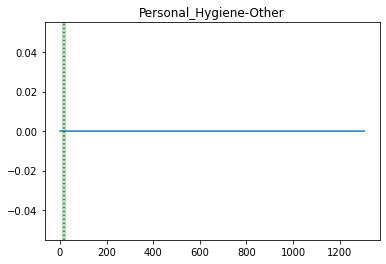

In [3]:
# PLOT
# SAMPLE

sensors = set()
for episode in episodes:
    sensors = sensors | set(episode[:,0])
sensors = sorted(sensors)

index = 0
episode, transition, label = episodes[index], transitions[index], labels[index]

feature = np.array(
    feature_extraction(episode, "hh101", sensors)
)

score = np.array(
    change_point_detection(feature, "SEP")
)

score[score<0]=0

tl, tr = float(episode[transition-1,2]), float(episode[transition,2])
lb, ub = transition-1, transition
while tl-float(episode[lb,2])<10. and lb!=0:
    lb-=1
while float(episode[ub,2])-tr<10. and ub!=len(episode)-1:
    ub+=1

# plt.subplot(1, 2, 1)
plt.title(label)
plt.plot(range(len(score)), score)
plt.axvline(
    transition, linestyle="dotted", color="g"
)
plt.axvspan(
    lb, ub, alpha=0.2, color='g'
)

In [ ]:
from scipy.spatial import distance_matrix

print(len(episode[:transition]), len(episode[transition:]), transition)
print([i for i in range(len(score)) if score[i]>0.05])
enumber = 120
print(score[enumber])

distance = distance_matrix(feature[enumber:enumber+2], feature[enumber+1:enumber+3])
print(distance)
print([(i, item) for i, item in enumerate(sensors)])

# sample = feature[enumber]-feature[enumber+1]
sample = feature[enumber]-feature[enumber+2]
# sample = feature[enumber+1]-feature[enumber+2]

diff_feature = sorted([(i, abs(sample[i])) for i in range(len(sample)) if sample[i]!=0.], key= lambda x: x[1], reverse=True)

print(episode[max(0, enumber-30+1):min(enumber+2+1, len(episode))])
diff_feature